In [14]:
import requests
import pandas as pd
import numpy as np

### Pull Data from the EIA API:

In [15]:
API_key = 'd1dc5b9854db1298722cdb011ed28c2b'

#   Run the first pull from the API outside of the for loop so that when you merge at the end you have a data frame to attach to.

id_one = 'ELEC.GEN.ALL-KS-99.M'
url = "http://api.eia.gov/series/?api_key="+API_key+"&series_id="+id_one
requested_url = requests.get(url)
x = requested_url.json()
data = x['series'][0]['data']
name = x['series'][0]['name']
df_x = pd.DataFrame(data, columns=['period', name])
df_x.head(12)

,period,Net generation : all fuels : Kansas : all sectors : monthly
0,201907,5029.27190
1,201906,4250.73298
2,201905,4120.23826
3,201904,3692.66184
4,201903,4112.58556
5,201902,4543.86660
6,201901,4473.07780
7,201812,4889.85217
8,201811,4101.80656
9,201810,4148.99672


### A Note on the weather data collection:

I collected temperature data from the National Oceanic and Atmospheric Administration. I picked a city that was relatively central to the main population areas of the state (Lawrence, KS) and searched for all weather data from each of the weather stations (34) in the area for the relevant time period April ’02 – July ’19. No single station had consistently reported temperature data for every month, so I took the average of those reporting (ranging from 1 to 5). I repeated this for each weather feature, Average Temperature (TAVG), Maximum Temperature (TMAX), and Minimum Temperature (TMIN).

In [16]:
weather = pd.read_csv('https://raw.githubusercontent.com/ldtownsend/DS7-Portfolio-Project-Energy/master/Lawrence_Temps.csv')
weather.head()

,period,TAVG,TMIN,TMAX
0,200204,56.733333,46.233333,67.200
1,200205,62.075000,51.125000,73.050
2,200206,76.150000,65.925000,86.300
3,200207,80.500000,69.200000,91.775
4,200208,78.875000,67.100000,90.675


# Create Features:

In [17]:
# Rename the target variable:
df_x['Net_Generation_KS'] = df_x['Net generation : all fuels : Kansas : all sectors : monthly']
df_x = df_x.drop(columns=['Net generation : all fuels : Kansas : all sectors : monthly'])

### Create Year and Month features

In [18]:
# Separate Month and Year as features
df_x['period'] = df_x['period'].astype(str)
df_x['Year'] = df_x['period'].str[:4].astype(int)
df_x['Month'] = df_x['period'].str[4:]
df_x['period'] = df_x['period'].astype(int)

### Create New Short-Term Time-Series Features
- Prior Month Year-over-Year (% Change)
- Prior 3-Months Year-over-Year (% Change)
- Prior 6-Months Year-over-Year (% Change)
- Prior 12-Months Year-over-Year (% Change)

In [19]:
# Function for creating any time range
def Prior_Period_YoY_Change(df_column=df_x['Net_Generation_KS'], prior_period_length=1):

    numerator = 0
    for i in range(prior_period_length + 1):
        numerator += df_column.shift(-i)

    denominator = 0
    for i in range(prior_period_length + 1):
        denominator += df_column.shift(-i - 12)

    return (1 - (numerator / denominator))

In [20]:
# Use the function to create 1, 3, 6, 12 month intervals
df_x['Prior_1Mo_YoY'] = Prior_Period_YoY_Change(prior_period_length=1)
df_x['Prior_3Mo_YoY'] = Prior_Period_YoY_Change(prior_period_length=3)
df_x['Prior_6Mo_YoY'] = Prior_Period_YoY_Change(prior_period_length=6)
df_x['Prior_12Mo_YoY'] = Prior_Period_YoY_Change(prior_period_length=12)

# Sort the dataframe by period
df_x = df_x.sort_values('period')
df_x.tail()

,period,Net_Generation_KS,Year,Month,Prior_1Mo_YoY,Prior_3Mo_YoY,Prior_6Mo_YoY,Prior_12Mo_YoY
4,201903,4112.58556,2019,03,-0.023691,0.008289,0.010808,-0.009917
3,201904,3692.66184,2019,04,-0.006888,0.005610,0.000230,-0.011499
2,201905,4120.23826,2019,05,-0.012238,-0.018225,0.000888,-0.013146
1,201906,4250.73298,2019,06,0.058759,0.028187,0.016206,-0.000247
0,201907,5029.27190,2019,07,0.037298,0.015271,0.017478,0.000288


### Merge with the Weather Data

In [21]:
df_x = pd.merge(df_x, weather, how='outer', on='period')
df_x.tail()

,period,Net_Generation_KS,Year,Month,Prior_1Mo_YoY,Prior_3Mo_YoY,Prior_6Mo_YoY,Prior_12Mo_YoY,TAVG,TMIN,TMAX
218,201903,4112.58556,2019,03,-0.023691,0.008289,0.010808,-0.009917,39.133333,28.733333,49.600
219,201904,3692.66184,2019,04,-0.006888,0.005610,0.000230,-0.011499,56.025000,44.400000,67.650
220,201905,4120.23826,2019,05,-0.012238,-0.018225,0.000888,-0.013146,62.025000,52.725000,71.325
221,201906,4250.73298,2019,06,0.058759,0.028187,0.016206,-0.000247,73.475000,63.050000,83.850
222,201907,5029.27190,2019,07,0.037298,0.015271,0.017478,0.000288,78.400000,68.400000,88.375


###  Start by Forecasting 12 Months

In [22]:
train = df_x[(df_x['period'] <= 201707) & (df_x['period'] >= 200301)] # April 2002 because the Prior_3Mo_YoY features returns NaNs before that. 
val = df_x[(df_x['period'] <= 201907) & (df_x['period'] >= 201708)]

In [23]:
# Define the target and features, ultra simple for this version.
target = 'Net_Generation_KS'
features = ['Year', 'Month', 'Prior_1Mo_YoY', 'Prior_3Mo_YoY', 'Prior_6Mo_YoY', 'Prior_12Mo_YoY', 'TAVG', 'TMIN', 'TMAX']

# Arrange data into X features and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [24]:
X_val.head()

,Year,Month,Prior_1Mo_YoY,Prior_3Mo_YoY,Prior_6Mo_YoY,Prior_12Mo_YoY,TAVG,TMIN,TMAX
199,2017,08,0.051188,0.014364,-0.008884,-0.017491,71.375,61.425,81.325
200,2017,09,-0.028725,-0.026090,-0.047261,-0.023395,70.425,59.450,81.450
201,2017,10,-0.271994,-0.081988,-0.064391,-0.055588,57.600,46.500,68.775
202,2017,11,-0.267041,-0.133248,-0.084794,-0.078874,43.975,33.550,54.425
203,2017,12,-0.131045,-0.196536,-0.084946,-0.080930,32.800,22.250,43.325


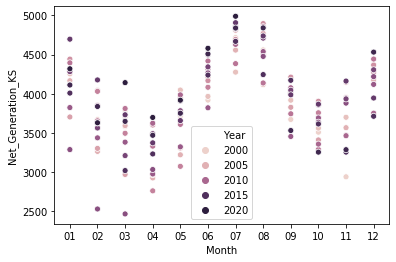

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=train.Month, y=train.Net_Generation_KS, hue=train.Year, legend="brief");

### Build models
- Random Forest

In [26]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline

In [27]:
# Random Forest:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
#     SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=5, random_state=15, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
rf_pred = pipeline.predict(X_val)

print(r2_score(y_val, rf_pred), mean_absolute_error(y_val, rf_pred), mean_squared_error(y_val, rf_pred))

0.049317193342957255 315.4966559166667 140675.2057351173


In [28]:
y_val

199    4194.00153
200    4416.15785
201    4212.46858
202    4072.24679
203    4767.93320
204    4945.94192
205    4219.30422
206    4236.81512
207    3515.03457
208    4203.40975
209    4690.13897
210    4949.40205
211    4815.62805
212    4267.02983
213    4148.99672
214    4101.80656
215    4889.85217
216    4473.07780
217    4543.86660
218    4112.58556
219    3692.66184
220    4120.23826
221    4250.73298
222    5029.27190
Name: Net_Generation_KS, dtype: float64

In [29]:
rf_pred

array([3759.39127 , 3803.551116, 3805.280268, 3789.906378, 4297.74815 ,
       4277.464882, 4001.359566, 3786.66611 , 3571.240292, 4052.269052,
       4625.866896, 4737.16919 , 4791.17504 , 3803.763306, 3643.685268,
       4018.940796, 4210.81791 , 4222.190186, 4023.108622, 3772.891228,
       3637.303046, 3844.712106, 4272.93325 , 4704.061134])

In [30]:
encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

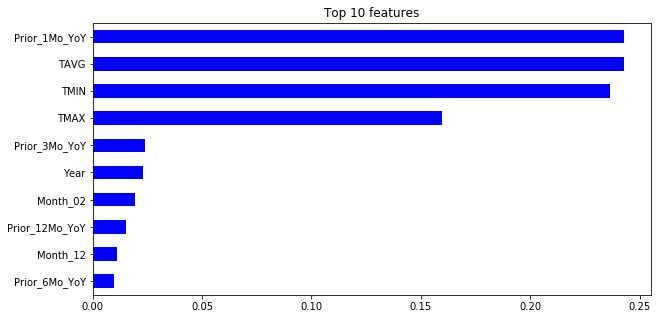

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

In [32]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

perm = PermutationImportance(pipeline).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.3423 ± 0.0469,x2
0.3157 ± 0.0563,x6
0.2962 ± 0.0434,x7
0.2551 ± 0.0804,x8
0.0256 ± 0.0100,x3
0.0239 ± 0.0100,x0
0.0142 ± 0.0064,x5
0.0135 ± 0.0079,x4
0.0000 ± 0.0000,x1


### Forecast the next month, then iterate the model:

In [33]:
# Define a function for iterating and refitting the model

def rf_iterate_model(start_train, end_train, start_test, end_test):

    # Get the test dates
    test_df_beg = df_x[(df_x['period'] <= end_test) & (df_x['period'] >= start_test).shift(-1)]
    test_df_end = df_x[df_x['period'] == end_test]
    test_df = pd.concat([test_df_beg, test_df_end])

    # Put the test set date range in order
    test_dates = test_df.period.sort_values()
    test_dates = test_dates.tolist()
    
    y_pred = []
    
    for i in range(len(test_dates)-1):
        train = df_x[(df_x['period'] <= test_dates[i]) & (df_x['period'] >= start_train)]
        
        X_train = train[features] # For now, features and target are global variables
        y_train = train[target] # For now, features and target are global variables
             
        test_month = test_df[test_df['period'] == test_dates[i+1]]

        X_test_month = test_month[features] # For now, features and target are global variables
        y_test_month = test_month[target] # For now, features and target are global variables
          
    
        # Decision Tree:
        rf = make_pipeline(
            ce.OneHotEncoder(use_cat_names=True), 
            RandomForestRegressor(n_estimators=5, random_state=15, n_jobs=-1)
        )

        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test_month)[0]
        
        y_pred.append(rf_pred)
        
    return y_pred

In [34]:
rf_iters_pred = rf_iterate_model(200301, 201707, 201708, 201907)
print(r2_score(y_val, rf_iters_pred), mean_absolute_error(y_val, rf_iters_pred), mean_squared_error(y_val, rf_iters_pred))

0.32860755467735203 248.15772016666673 99347.82633429812


In [35]:
df_results_with_iteration = pd.DataFrame(rf_iters_pred)
df_results_with_iteration.columns= ['Net_Generation_KS']
df_results_with_iteration['Results_Type'] = 'With Iteration' 
df_results_with_iteration['period'] = val['period'].values

df_results_no_iteration = pd.DataFrame(rf_pred)
df_results_no_iteration.columns= ['Net_Generation_KS']
df_results_no_iteration['Results_Type'] = 'No Iteration' 
df_results_no_iteration['period'] = val['period'].values

df_results_actual = pd.DataFrame(val['Net_Generation_KS'].values)
df_results_actual.columns= ['Net_Generation_KS']
df_results_actual['Results_Type'] = 'Actual' 
df_results_actual['period'] = val['period'].values
# df_results_actual.shape, df_results_no_iteration.shape, df_results_with_iteration.shape

display_results = pd.concat([df_results_with_iteration, df_results_no_iteration, df_results_actual])
display_results

,Net_Generation_KS,Results_Type,period
0,3759.391270,With Iteration,201708
1,3858.924212,With Iteration,201709
2,3801.030726,With Iteration,201710
3,4019.748852,With Iteration,201711
4,4297.748150,With Iteration,201712
5,4401.402962,With Iteration,201801
6,4043.577896,With Iteration,201802
7,3936.551352,With Iteration,201803
8,4046.830334,With Iteration,201804
9,4265.379392,With Iteration,201805
